In [23]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [20]:
def plot_dist_hist_for(encoded_vectors, targets, mode='cosine'):

    def get_dist_mat(encoded_batch, mode=mode):
        
        if mode == 'cosine':
    
            def cosine_dist_matrix(batch1, batch2, dim=1, eps=1e-8):
                # Normalize the batches along the specified dimension
                batch1_norm = batch1 / torch.norm(batch1, dim=dim, keepdim=True).clamp(min=eps)
                batch2_norm = batch2 / torch.norm(batch2, dim=dim, keepdim=True).clamp(min=eps)
        
                # Calculate the cosine similarity matrix
                similarity_matrix = torch.mm(batch1_norm, batch2_norm.transpose(0, 1))
                return 1-similarity_matrix
        
            image_features_1 = encoded_batch
            image_features_1 /= image_features_1.norm(dim=-1, keepdim=True)
            dist_matrix = cosine_dist_matrix(image_features_1, image_features_1, dim=-1)
        
            return dist_matrix/dist_matrix.max()
        
        elif mode == 'euclidean':
            dist = torch.cdist(encoded_batch, encoded_batch)**2
            # print(encoded_batch.shape)
            return dist/dist.max()
            # return dist
        
        elif mode == 'euclidean_2':
            dist = torch.cdist(encoded_batch, encoded_batch)
            return dist/dist.max()
        
        else:
            raise ValueError(f'Unknown mode: {mode}')
    
    # get the distance matrix for the cross-class
    num_per_class_cross = 20
    encoded_batch_list = [encoded_vectors[targets == i][:num_per_class_cross] for i in range(targets.max()+1)]
    
    cross_cls_batch_list = []
    for idx in range(num_per_class_cross):
        cross_cls_batch = torch.vstack([encoded_batch[idx] for encoded_batch in encoded_batch_list])
        cross_cls_batch_list.append(cross_cls_batch)
    cross_cls_dist_matrix_list = torch.stack([get_dist_mat(cross_cls_batch) for cross_cls_batch in cross_cls_batch_list])
    cross_dist = cross_cls_dist_matrix_list.flatten()[cross_cls_dist_matrix_list.flatten() >= 1e-4]
    
    # get the distance matrix for the inter-class
    num_per_class_inter = 43
    encoded_batch_list = [encoded_vectors[targets == i][:num_per_class_inter] for i in range(targets.max())]
    dist_matrix_list = torch.stack([get_dist_mat(encoded_batch) for encoded_batch in encoded_batch_list])
    inter_class = dist_matrix_list.flatten()[dist_matrix_list.flatten() >= 1e-4]
        
    inter_class_prop_list = []
    cross_class_prop_list = []
    x_ticks = np.arange(0, 1, 0.01)
    for x_tick in x_ticks:
        inter_class_prop = torch.sum(inter_class < x_tick) / len(inter_class)
        cross_class_prop = torch.sum(cross_dist < x_tick) / len(cross_dist)
        
        inter_class_prop_list.append(inter_class_prop)
        cross_class_prop_list.append(cross_class_prop)
    
    # convert list to numpy array
    inter_class_prop_arr = np.array(inter_class_prop_list)
    cross_class_prop_arr = np.array(cross_class_prop_list)
    diff_prop_arr = inter_class_prop_arr - cross_class_prop_arr
    argmax_diff = np.argmax(diff_prop_arr)
    
    # print the max difference
    print(f'Max difference: {x_ticks[argmax_diff]} at {argmax_diff}')
    
    # train a logistic regression model
    X = np.concatenate([inter_class, cross_dist]).reshape(-1, 1)
    y = np.concatenate([np.zeros(len(inter_class)), np.ones(len(cross_dist))])
    clf = LogisticRegression(random_state=0).fit(X, y)
        
    y_ticks = clf.predict_proba(x_ticks.reshape(-1, 1))[:,1]
    
    coef = clf.coef_[0]  # weight (slope)
    intercept = clf.intercept_  # bias (intercept)
    print(f'coef: {coef}, intercept: {intercept}')
    def sigmoid(x):
        return 1 / (1 + np.exp(-(coef * x + intercept)))
    
    y_ticks_saved = sigmoid(x_ticks)
        
    # plot two histograms in one figure with legend
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].hist(inter_class, bins=200, alpha=0.5, label='Inter-class')
    ax[0].hist(cross_dist, bins=200, alpha=0.5, label='Cross-class')
    ax[0].axvline(x_ticks[argmax_diff], color='r', linestyle='--', label='Max diff')
    ax[0].set_xlim([0, 1])
    ax[0].legend()
    
    # plot the logit regression
    ax[1].plot(x_ticks, inter_class_prop_arr, label='Inter-class')
    ax[1].plot(x_ticks, cross_class_prop_arr, label='Cross-class')
    # ax[1].plot(x_ticks, diff_prop_arr, label='Inter-class - Cross-class')
    ax[1].plot(x_ticks, y_ticks, label='Logistic regression')
    ax[1].plot(x_ticks, y_ticks_saved, label='Logistic regression saved')
    ax[1].axvline(x_ticks[argmax_diff], color='r', linestyle='--', label='Max diff')
    ax[1].set_xlim([0, 1])
    ax[1].legend()
    plt.title(f'{mode} distance distribution')
    plt.show()

In [5]:
images_batch1, encoded_vectors1, targets1 = torch.load(os.path.join('./data', 'encoded_FairFace/encoded_FairFace_train_gender_0_ViT-H-14-378-quickgelu_dfn5b_64.pth'))
images_batch2, encoded_vectors2, targets2 = torch.load(os.path.join('./data', 'encoded_FairFace/encoded_FairFace_train_gender_1_ViT-H-14-378-quickgelu_dfn5b_64.pth'))

In [21]:
images_batch1, encoded_vectors1, targets1 = torch.load(os.path.join('./data', 'encoded_office31/encoded_office31_train_amazon_ViT-H-14-378-quickgelu_dfn5b_64.pth'))
# images_batch2, encoded_vectors2, targets2 = torch.load(os.path.join('./data', 'encoded_office31/encoded_office31_train_dslr_ViT-H-14-378-quickgelu_dfn5b_64.pth'))

In [22]:
# encoded_vectors = torch.vstack((encoded_vectors1, encoded_vectors2))
# targets = torch.vstack((targets1, targets2))
print(targets1.shape)
print(encoded_vectors1.shape)
# plot_dist_hist_for(encoded_vectors, targets, mode='cosine')
plot_dist_hist_for(encoded_vectors1, targets1, mode='euclidean')
# targets = torch.vstack((targets1, targets2))

# plot_dist_hist_for(encoded_vectors, targets, mode='euclidean')
# plot_dist_hist_for(encoded_vectors, targets, mode='euclidean_2')

torch.Size([2255])
torch.Size([2255, 1024])


RuntimeError: stack expects each tensor to be equal size, but got [43, 43] at entry 0 and [30, 30] at entry 4

In [88]:
images_batch, encoded_vectors, targets = torch.load(os.path.join('../data', 'encoded_usps/encoded_usps_train_ViT-L-14_commonpool_xl_s13b_b90k_28.pth'))

Max difference: 0.45 at 45
coef: [8.35274271], intercept: [-4.24849958]


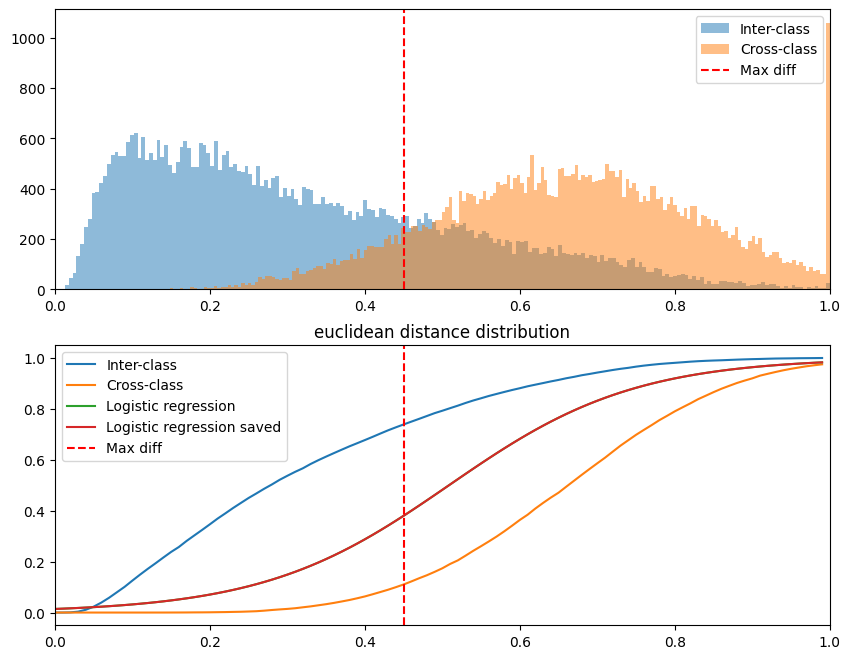

In [89]:
# plot_dist_hist_for(encoded_vectors, targets, mode='cosine')
plot_dist_hist_for(encoded_vectors, targets, mode='euclidean')
# plot_dist_hist_for(encoded_vectors, targets, mode='euclidean_2')

In [6]:
import os

images_batch, encoded_vectors, targets = torch.load(os.path.join('../data', 'encoded_syn/encoded_syn_train_ViT-H-14-378-quickgelu_dfn5b_32.pth'))

Max difference: 0.56 at 56


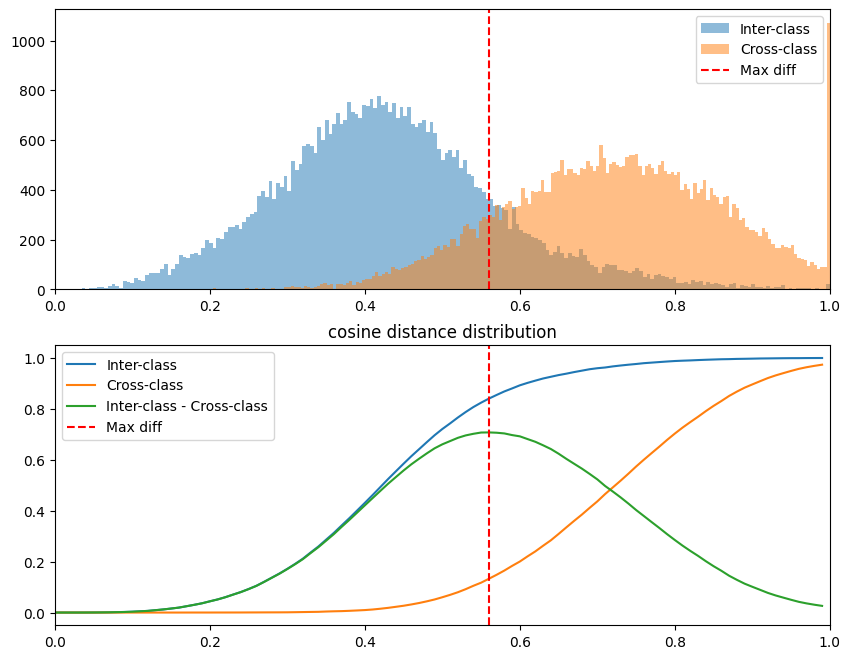

Max difference: 0.5700000000000001 at 57


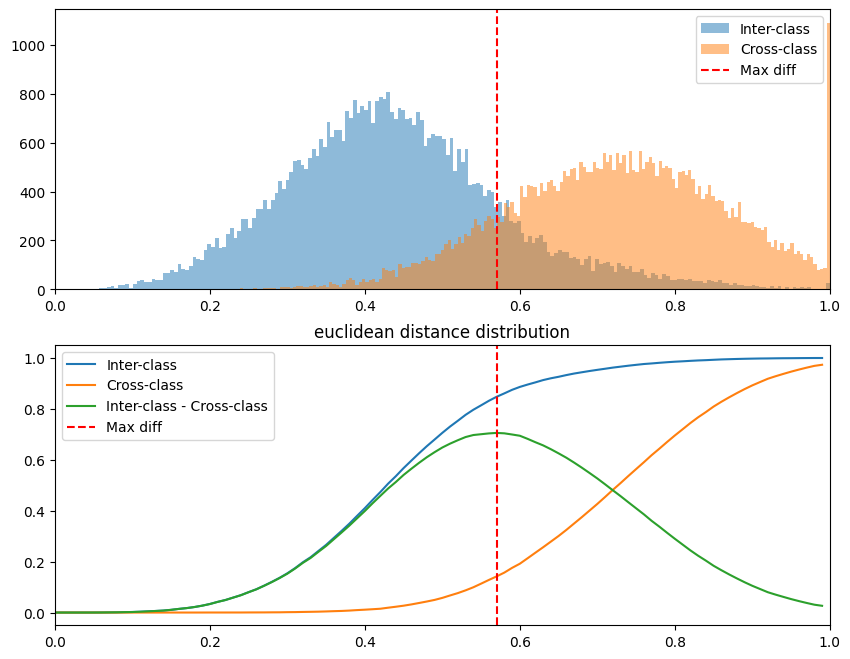

In [7]:
plot_dist_hist_for(encoded_vectors, targets, mode='cosine')
plot_dist_hist_for(encoded_vectors, targets, mode='euclidean')

In [9]:
import os

images_batch, encoded_vectors, targets = torch.load(os.path.join('../data', 'encoded_mnistm/encoded_mnistm_train_ViT-H-14-378-quickgelu_dfn5b_28.pth'))

Max difference: 0.29 at 29


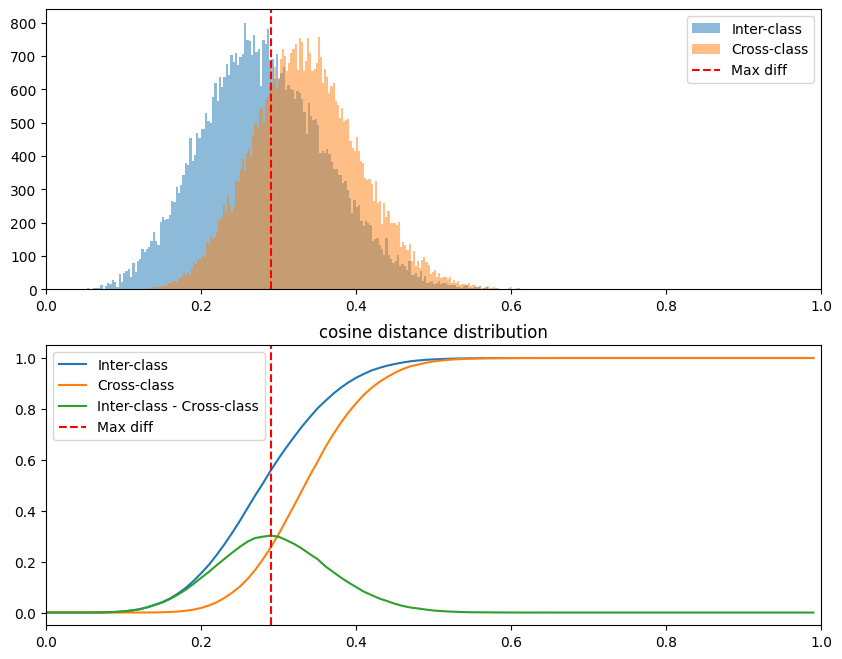

Max difference: 0.48 at 48


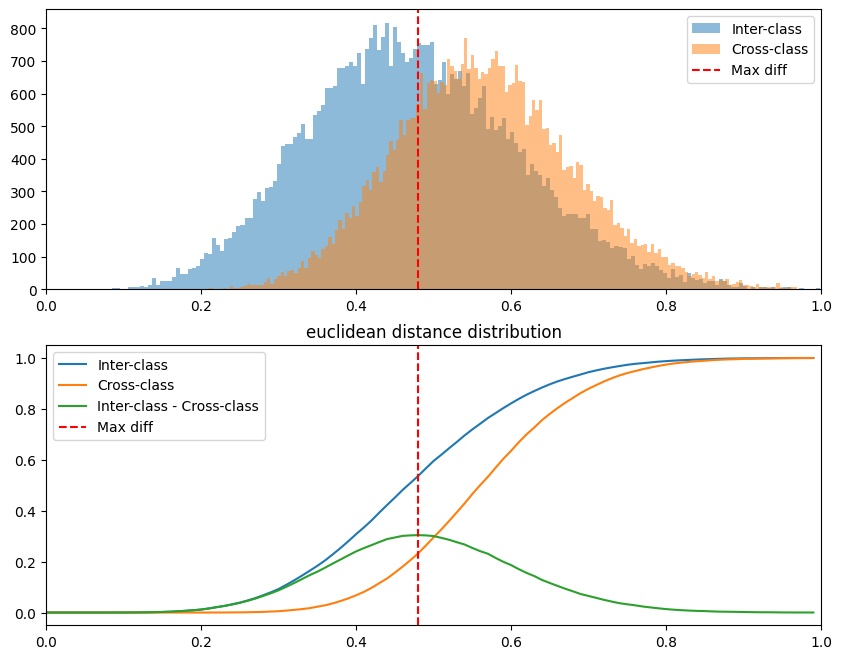

In [12]:
plot_dist_hist_for(encoded_vectors, targets, mode='cosine')
plot_dist_hist_for(encoded_vectors, targets, mode='euclidean')

In [13]:
# generate a random matrix
import torch
import numpy as np

x = torch.randn(10, 10)
print(x.max())

tensor(2.2925)


In [94]:
import os
images_batch, encoded_vectors, targets = torch.load(os.path.join('../data', 'encoded_svhn/encoded_svhn_test_ViT-L-14_commonpool_xl_clip_s13b_b90k_32.pth'))

Max difference: 0.5700000000000001 at 57
coef: [6.03675488], intercept: [-3.41930965]


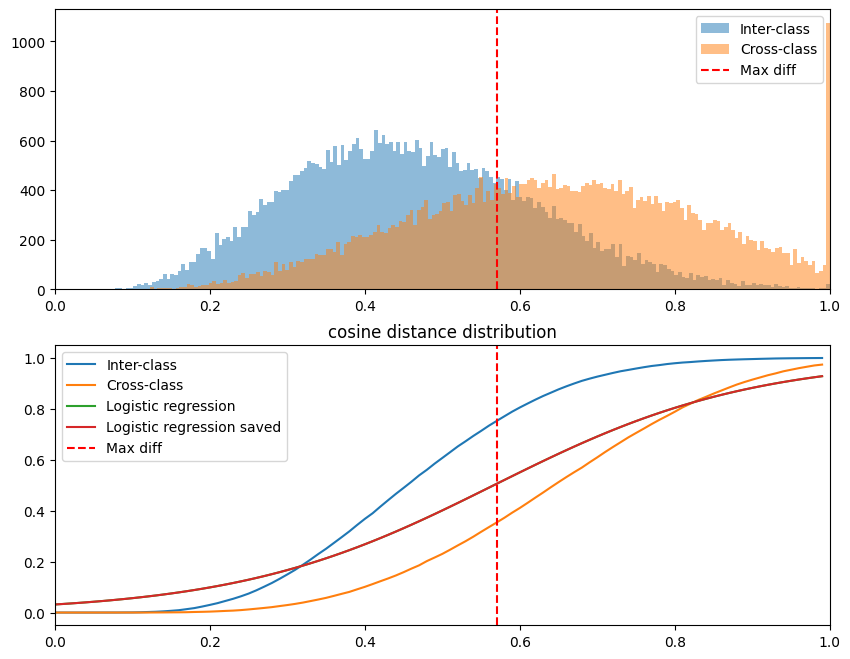

In [96]:
plot_dist_hist_for(encoded_vectors, targets, mode='cosine')